In [7]:
# include path ../src in order to import modules
import sys
sys.path.append('../src')
import TCT as TCT
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [8]:
TCT.TCT_help(TCT.format_query_json)


    Example input:
    subject_ids = ["NCBIGene:3845"]
    object_ids = []
    subject_categories = ["biolink:Gene"]
    object_categories = ["biolink:Gene"]
    predicates = ["biolink:positively_correlated_with", "biolink:physically_interacts_with"]

    


In [9]:
# Step1: List all the APIs in the translator system
APInames = TCT.list_Translator_APIs()
print(len(APInames))

#for name in (APInames.keys()):
#    print(name)

65


In [10]:
# Step 2: Get metaKG from Translator APIs
metaKG = TCT.get_KP_metadata(APInames) # This only applies to the Translator APIs
print(metaKG.columns)
print(metaKG.shape)

#metaKG.to_csv('metaKG.csv', index=False)
#metaKG = pd.read_csv('../metaData/metaKG.csv')


Index(['API', 'KG_category', 'Subject', 'Object', 'URL'], dtype='object')
(11045, 5)


In [11]:
# Step 3 (optional): add new metaKG from a user defined API
APInames, metaKG = TCT.add_new_API_for_query(APInames, metaKG, "UserAPI", "http://127.0.0.1:8000/find_path_by_predicate", "biolink:physically_interacts_with", "biolink:Gene", "biolink:Gene")
print(metaKG.shape)

(11046, 5)


In [12]:
query_json = TCT.format_query_json(subject_ids=["NCBIGene:64102"], object_ids=[], subject_categories=["biolink:Gene"], object_categories = ["biolink:Gene"], predicates=["biolink:physically_interacts_with"])
result = TCT.parallel_api_query(list(APInames.values()),query_json=query_json, max_workers=20)
result_parsed = TCT.parse_KG(result)
result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, "NCBIGene:64102")

'https://automat.ci.renci.org/drugcentral/1.4/query' generated an exception: HTTPSConnectionPool(host='automat.ci.renci.org', port=443): Max retries exceeded with url: /drugcentral/1.4/query (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x13ec0cf70>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
Error: 403
Error: 400
Error: 400
Error: 404
Error: 404
Error: 404
Error: 404
Error: 404
Error: 400
Error: 404
Error: 404
Error: 404


In [13]:
result_parsed.keys()

dict_keys(['NCBIGene:64102_NCBIGene:4000', 'NCBIGene:64102_NCBIGene:3008', 'NCBIGene:64102_NCBIGene:84283', 'NCBIGene:64102_NCBIGene:945', 'NCBIGene:64102_NCBIGene:200232', 'NCBIGene:64102_NCBIGene:664', 'NCBIGene:64102_NCBIGene:115653', 'NCBIGene:64102_NCBIGene:6676', 'NCBIGene:64102_NCBIGene:665', 'NCBIGene:64102_NCBIGene:124975', 'NCBIGene:64102_NCBIGene:57463', 'NCBIGene:64102_NCBIGene:113277', 'NCBIGene:64102_NCBIGene:23786', 'NCBIGene:64102_NCBIGene:11148', 'NCBIGene:64102_NCBIGene:2209', 'NCBIGene:64102_NCBIGene:90993', 'NCBIGene:64102_NCBIGene:200894', 'NCBIGene:64102_NCBIGene:60314', 'NCBIGene:84283_NCBIGene:64102'])

<AxesSubplot:title={'center':'Ranking of one-hop nodes by predicate'}, ylabel='Predicate'>

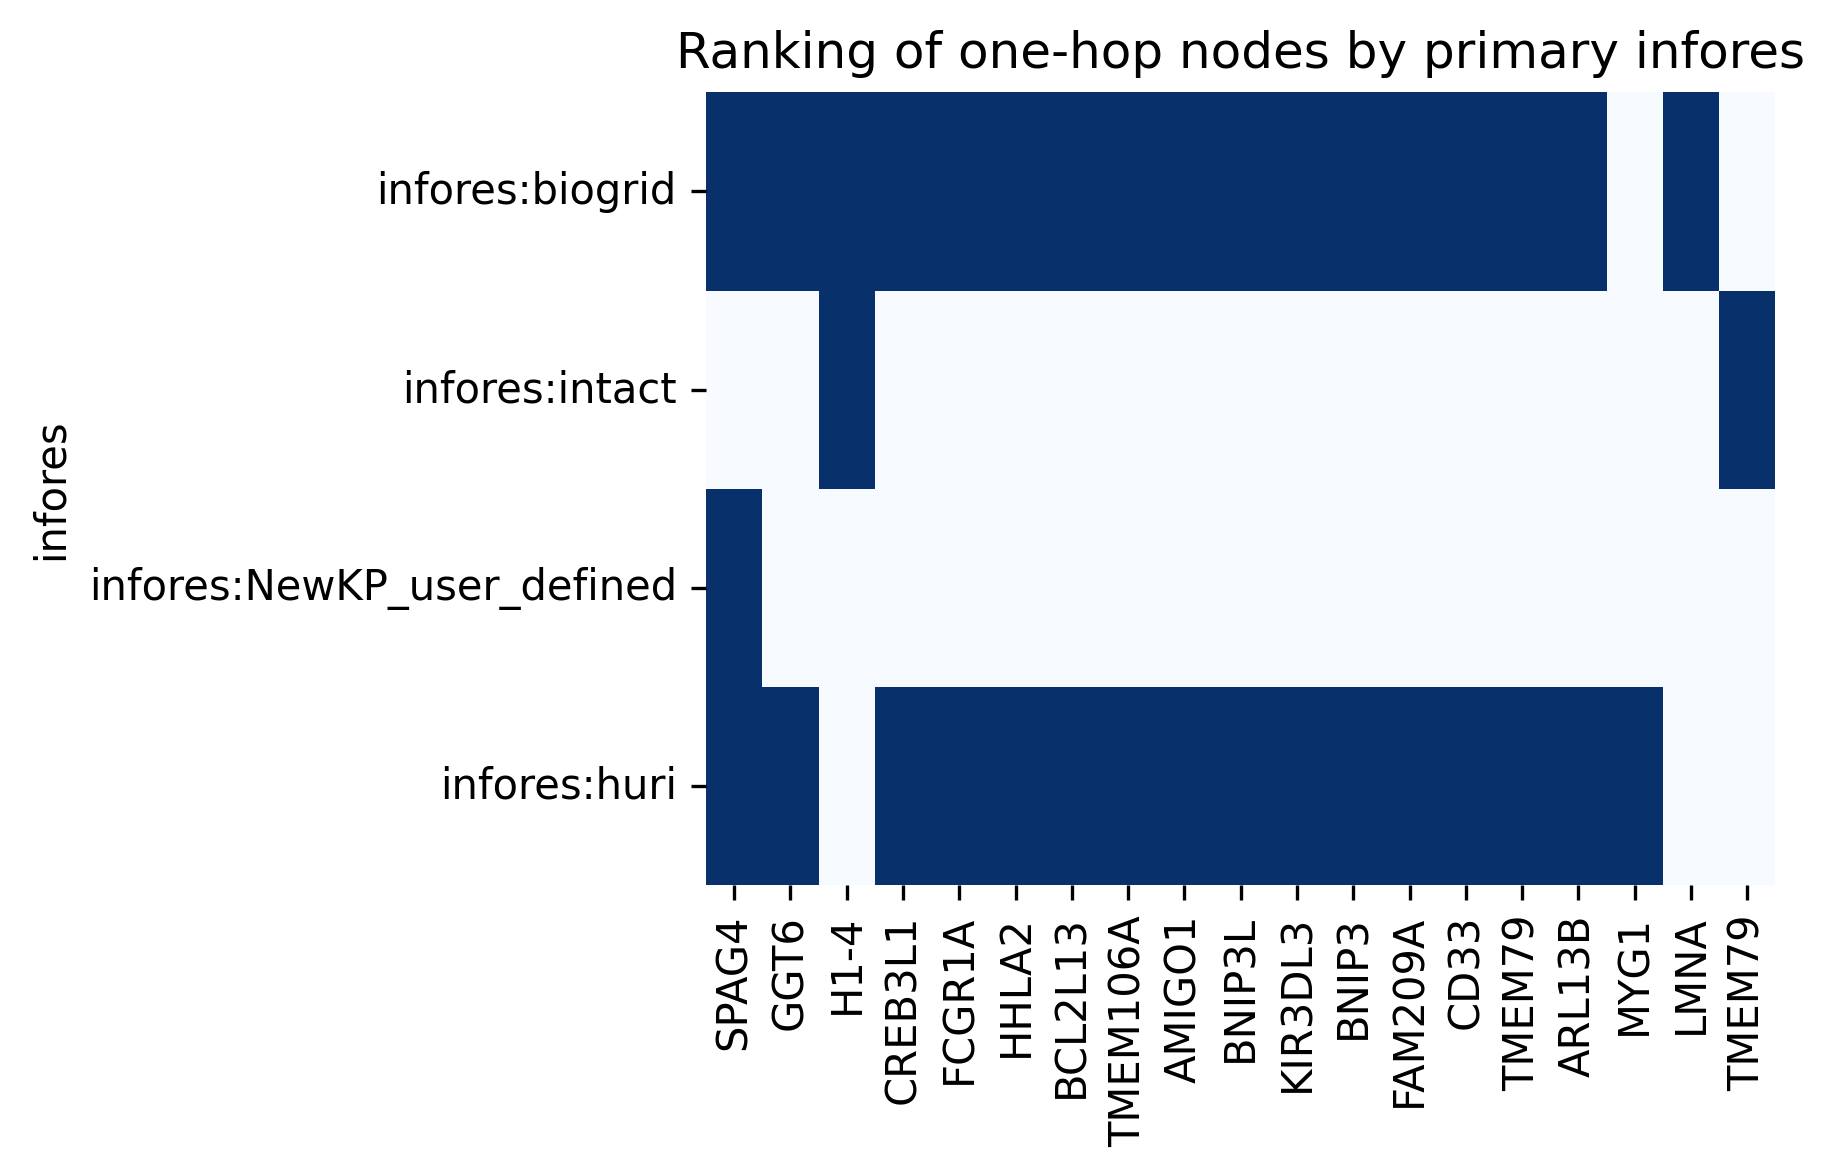

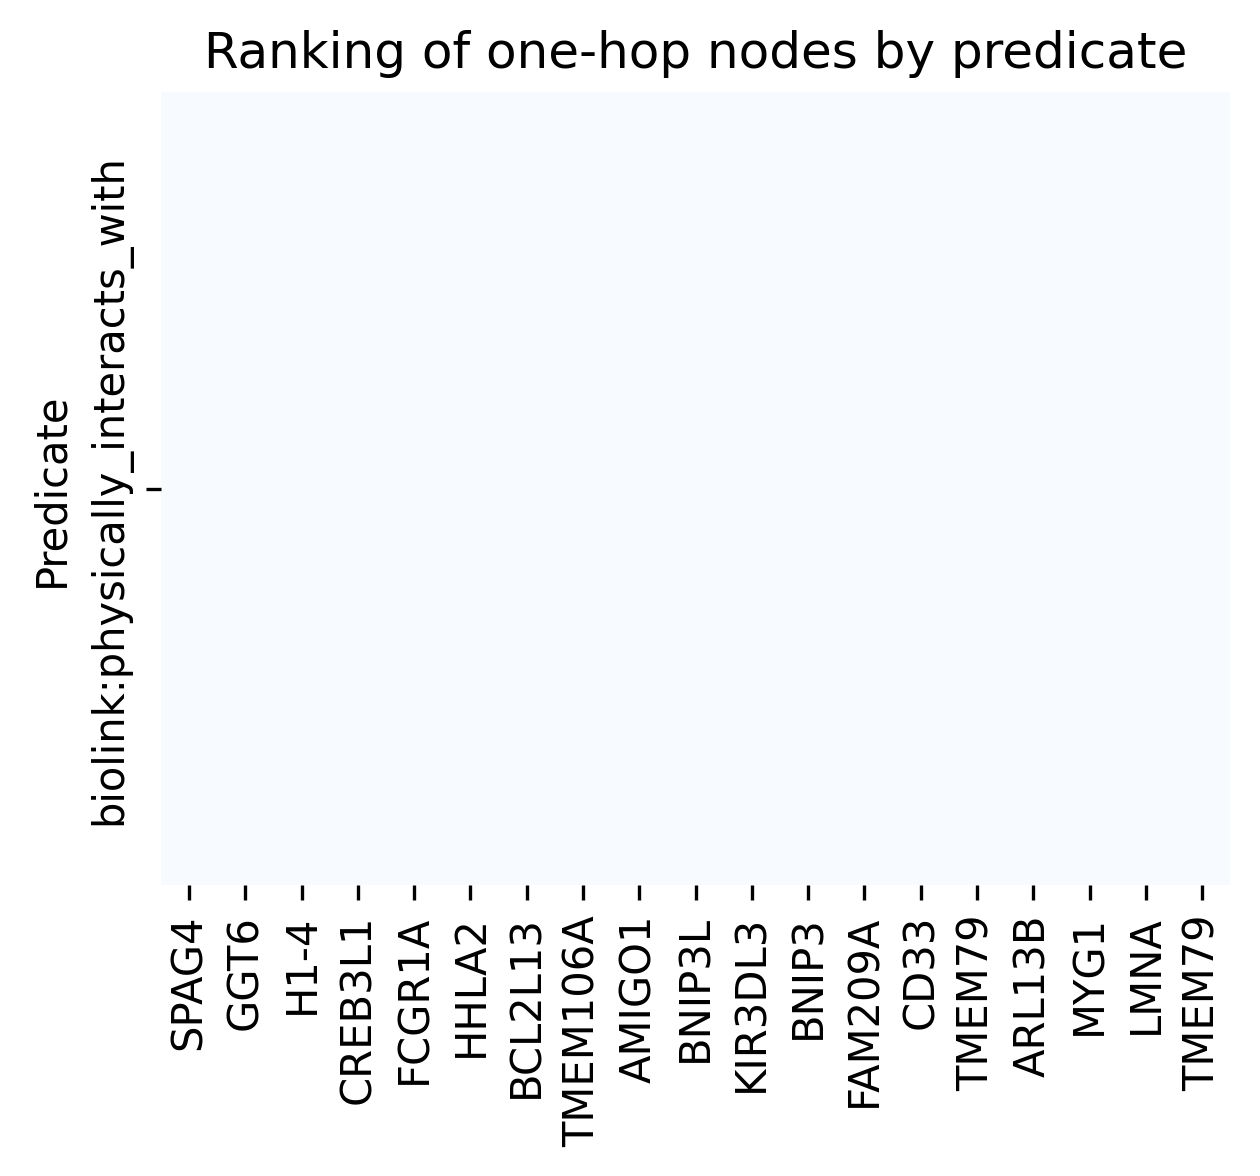

In [16]:
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, result_parsed, num_of_nodes = 100, input_query = "NCBIGene:64102")

In [ ]:
# End of the example